In [9]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [10]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [11]:
# Creating a table with all accepted offers in the last 28 days
sql = '''
SELECT carrier_name, carrier_type, status, carrier_guid, order_id, date(accepted_date) 
FROM stms_db2_shipper.offers
WHERE status IN ('paid', 'delivered', 'accepted', 'picked_up', 'invoiced')
AND accepted_date >= date(current_date - interval '28 days')
AND accepted_date < date(current_date)
'''
offers = pd.read_sql_query(sql, con=engine)
offers = offers.rename(columns={'date': 'accepted_date'})
# update so we dont have any half days

In [12]:
# offers table
offers.head()

,carrier_name,carrier_type,status,carrier_guid,order_id,accepted_date
0,WILD WEST EXPRESS LLC,CTMS,paid,949b20a1-566b-43fa-83a9-6a8cce770b1f,1052784,2020-12-08
1,DUTCHWAY FREIGHT LTD,CTMS,delivered,70883b73-9d96-4752-879c-fe8901d57e26,1053681,2020-12-08
2,ESTRADA'S TRANSPORTATION LLC,CTMS,paid,a59a4f98-7da5-4e20-a91a-58092ca9f83d,1053756,2020-12-08
3,AUTHENTIC AUTO TRANSPORT CO,CTMS,paid,b00970ac-6c41-4752-ae9d-b7d50fcbd2dd,1053176,2020-12-08
4,REIGN CONSULTING,CTMS,invoiced,ed822e80-7e6a-48b6-8089-efd62f35292d,1053889,2020-12-08


In [13]:
# offers table data types
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31871 entries, 0 to 31870
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   carrier_name   31871 non-null  object
 1   carrier_type   31871 non-null  object
 2   status         31871 non-null  object
 3   carrier_guid   31870 non-null  object
 4   order_id       31871 non-null  int64 
 5   accepted_date  31871 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [14]:
# Descriptive statistics for offers table
offers.describe(include='all')

,carrier_name,carrier_type,status,carrier_guid,order_id,accepted_date
count,31871,31871,31871,31870,3.187100e+04,31871
unique,2811,3,5,2807,NaN,28
top,VALKEN GROUP LLC,CTMS,paid,51095e90-fee6-47fc-b220-ab189041a780,NaN,2020-12-17
freq,3651,31808,16367,3651,NaN,2381
mean,NaN,NaN,NaN,NaN,1.070657e+06,NaN
std,NaN,NaN,NaN,NaN,1.237791e+04,NaN
min,NaN,NaN,NaN,NaN,6.095430e+05,NaN
25%,NaN,NaN,NaN,NaN,1.061582e+06,NaN
50%,NaN,NaN,NaN,NaN,1.070769e+06,NaN
75%,NaN,NaN,NaN,NaN,1.080002e+06,NaN


In [15]:
# Offers table after date and time have been truncated
offers.head()

,carrier_name,carrier_type,status,carrier_guid,order_id,accepted_date
0,WILD WEST EXPRESS LLC,CTMS,paid,949b20a1-566b-43fa-83a9-6a8cce770b1f,1052784,2020-12-08
1,DUTCHWAY FREIGHT LTD,CTMS,delivered,70883b73-9d96-4752-879c-fe8901d57e26,1053681,2020-12-08
2,ESTRADA'S TRANSPORTATION LLC,CTMS,paid,a59a4f98-7da5-4e20-a91a-58092ca9f83d,1053756,2020-12-08
3,AUTHENTIC AUTO TRANSPORT CO,CTMS,paid,b00970ac-6c41-4752-ae9d-b7d50fcbd2dd,1053176,2020-12-08
4,REIGN CONSULTING,CTMS,invoiced,ed822e80-7e6a-48b6-8089-efd62f35292d,1053889,2020-12-08


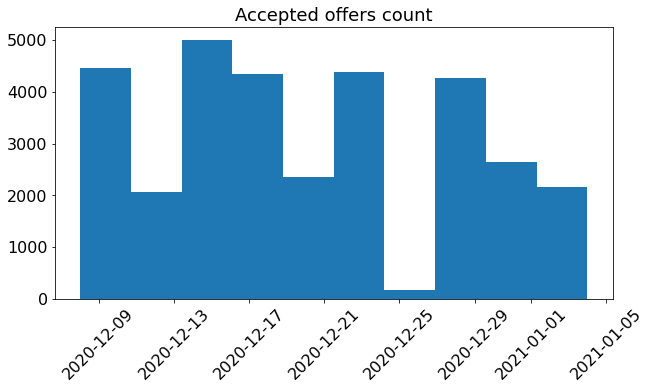

In [16]:
# Distribution of accepted offers by date
# Everything appears normal as the low points include weekends which we would expect less offers accepted
plt.figure(figsize=(10,5))
plt.xticks(rotation=45, size=16)
plt.yticks(size=16)
plt.title('Accepted offers count', size=18)
plt.hist(offers['accepted_date'])
plt.show()

In [17]:
# Checking for missing values in every column
missing_values = offers.isna().sum()
missing_values

carrier_name     0
carrier_type     0
status           0
carrier_guid     1
order_id         0
accepted_date    0
dtype: int64

In [18]:
# Grouping the offers table to get the unique number of days a carrier accpeted an offer in last 28 days
offers_28_days = offers.groupby(['carrier_name', 'carrier_guid'])[['accepted_date']].nunique()
offers_28_days.reset_index(inplace=True)
offers_28_days = offers_28_days.rename(columns={'accepted_date': 'accepted_offers_28_days'})
offers_28_days

,carrier_name,carrier_guid,accepted_offers_28_days
0,1 CALL AWAY,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,4
1,1 DAY AUTO TRANSPORT LLC,e7099505-fd84-4b33-b516-619c3dba082b,1
2,121 Towing,431dc4ab-d720-445a-816e-e046167b0f76,1
3,1ST CHOICE TRANSPORT,9cce6727-adef-40e3-95d7-0b5bfe237ec9,2
4,2 BROTHER'S EXPRESS TRANSPORT INC,81064a2c-5c6a-49a1-9913-699978b2061c,1
...,...,...,...
2809,eco transport,17e62317-e67d-4394-97cb-fcb319d471c3,2
2810,mj parker,13de9609-5f96-43cd-a15e-0765a91613ad,1
2811,peker transportation,8a82a6e7-f15b-4b74-8f23-a09f09d8c93d,6
2812,ref ref,81cc99a5-083b-4346-a369-71ef0efa5e2f,2


In [19]:
# Creating a table with all drivers
sql = '''
SELECT genericuser_ptr_id, carrier_id, guid
FROM ctms_db_public.msd_driver
WHERE is_suspended = False
'''
drivers = pd.read_sql_query(sql, con=engine)
drivers = drivers.rename(columns={'guid': 'driver_guid'})
drivers.head()

,genericuser_ptr_id,carrier_id,driver_guid
0,90,33,79222199-144b-4fe5-b7d9-1315f085ecb5
1,107,46,3b528706-8e0d-46b8-95c3-5d19b72d4d7c
2,124,59,f6122539-d39b-4ca5-846d-5841e2dd8871
3,143,5478,739117c9-8150-4f7e-af85-0822c8fa4605
4,163,5478,d5c78a89-8c45-45d1-91ec-17e5833b8e16


In [20]:
# The driver table needs carrier_guid. 
# I need the carrier table to join carrier_guid on the driver table
sql = '''
SELECT name, id, guid
FROM ctms_db_public.msd_carrier
'''
carriers = pd.read_sql_query(sql, con=engine)
carriers = carriers.rename(columns={'id': 'carrier_id', 'guid': 'carrier_guid'})
carriers.head()

,name,carrier_id,carrier_guid
0,J&T Wrecker Service LLC,33,9e446db7-d3dd-443e-a16e-b9edf7685e05
1,Prime Track Inc,167,45c2d62f-50f8-464b-9d8b-289c22af3a8e
2,Real Deal Auto Clinic Inc.,171,4dfb1eea-8eed-4156-9924-9776a2b0b6f0
3,AS trucking llc,211,f2584277-d577-430f-932a-003254a6fdcc
4,FM Auto trans,229,ef862060-9260-4204-863c-259bdc74a8f4


In [21]:
# Joining carrier_guid on driver table
drivers = drivers.merge(carriers, how='left', left_on='carrier_id', right_on='carrier_id')
drivers.head()

,genericuser_ptr_id,carrier_id,driver_guid,name,carrier_guid
0,90,33,79222199-144b-4fe5-b7d9-1315f085ecb5,J&T Wrecker Service LLC,9e446db7-d3dd-443e-a16e-b9edf7685e05
1,107,46,3b528706-8e0d-46b8-95c3-5d19b72d4d7c,RA National Transport,c7a903c6-fcb0-4656-bd4d-d57253991b37
2,124,59,f6122539-d39b-4ca5-846d-5841e2dd8871,TECHNECY,65923adb-2d77-44b6-8a90-2fc465eb7155
3,143,5478,739117c9-8150-4f7e-af85-0822c8fa4605,DUMMY ACCOUNT (DO NOT ACTIVATE),9421bc9d-fa9e-49d1-9a07-e5570d3c0b74
4,163,5478,d5c78a89-8c45-45d1-91ec-17e5833b8e16,DUMMY ACCOUNT (DO NOT ACTIVATE),9421bc9d-fa9e-49d1-9a07-e5570d3c0b74


In [22]:
# getting the unique number of drivers for each carrier
active_driver_count = drivers.groupby(['carrier_guid', 'name'])[['genericuser_ptr_id']].nunique()
active_driver_count.reset_index(inplace=True)
active_driver_count = active_driver_count.rename(columns={'genericuser_ptr_id': 'activated_drivers'})
active_driver_count

,carrier_guid,name,activated_drivers
0,000243e7-afae-455a-8e61-5c691916f39e,PERFECT SERVICES LLC,1
1,0004758e-daf4-4d3f-8257-be49db385d8e,Flete,1
2,000acb9e-e4bb-4cff-a5b3-3bedcf05babf,R-MICHAEL ENT LLC,1
3,000b7030-5bfc-4c95-8627-df29412347ff,MACROD TOWING LLC,1
4,000b8e63-986b-4bae-befe-22481e2bfc9c,AB TRANSPORT SERVICE,1
...,...,...,...
38328,fff8e9ba-cbcd-4bf7-8f92-b00fba5ba543,Alpha Transport,1
38329,fffa8e6a-3943-47f5-bc00-52f59d9cd0c6,NEAGU INC,1
38330,fffb578c-7297-4ade-996d-eef9aed6c22c,SAM TRANSPORT LLC,1
38331,ffff3737-7524-40a4-b225-a8832c96bf91,Gshsh,1


In [23]:
# joining the activated drivers on the 'offers_28_days' table
result_1 = offers_28_days.merge(active_driver_count[['carrier_guid', 'activated_drivers']], how='left', left_on='carrier_guid', right_on='carrier_guid')
result_1

,carrier_name,carrier_guid,accepted_offers_28_days,activated_drivers
0,1 CALL AWAY,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,4,5.0
1,1 DAY AUTO TRANSPORT LLC,e7099505-fd84-4b33-b516-619c3dba082b,1,1.0
2,121 Towing,431dc4ab-d720-445a-816e-e046167b0f76,1,NaN
3,1ST CHOICE TRANSPORT,9cce6727-adef-40e3-95d7-0b5bfe237ec9,2,1.0
4,2 BROTHER'S EXPRESS TRANSPORT INC,81064a2c-5c6a-49a1-9913-699978b2061c,1,1.0
...,...,...,...,...
2809,eco transport,17e62317-e67d-4394-97cb-fcb319d471c3,2,3.0
2810,mj parker,13de9609-5f96-43cd-a15e-0765a91613ad,1,1.0
2811,peker transportation,8a82a6e7-f15b-4b74-8f23-a09f09d8c93d,6,1.0
2812,ref ref,81cc99a5-083b-4346-a369-71ef0efa5e2f,2,1.0


In [24]:
result_1.isna().sum()/result_1.isna().count()

carrier_name               0.000000
carrier_guid               0.000000
accepted_offers_28_days    0.000000
activated_drivers          0.024165
dtype: float64

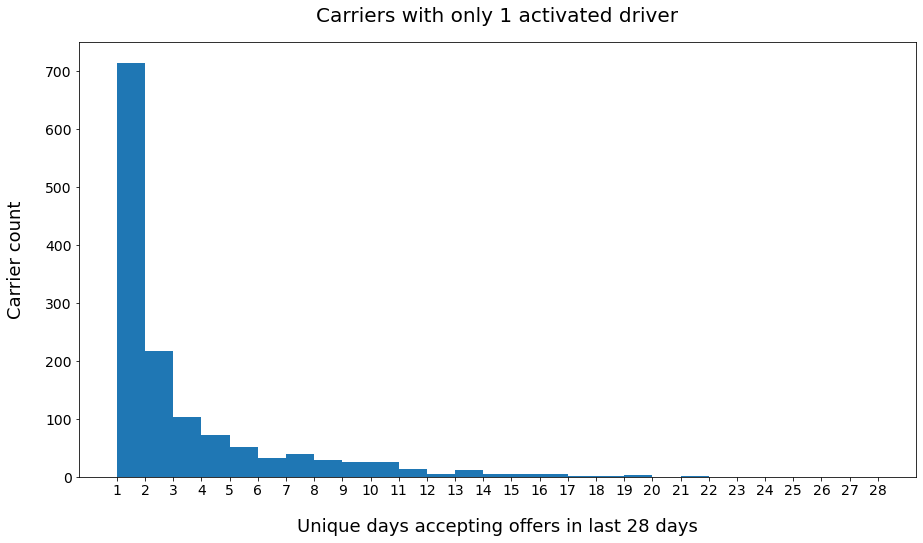

In [25]:
# histogram of unique accepted offers in last 28 days
plt.figure(figsize=(15,8))
plt.hist(result_1[result_1['activated_drivers'] == 1]['accepted_offers_28_days'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Unique days accepting offers in last 28 days', fontsize=18, labelpad=20)
plt.ylabel('Carrier count', fontsize=18, labelpad=20)
plt.title('Carriers with only 1 activated driver', fontsize=20, pad=20)
plt.show()

# Results
Most carriers are only accepting offers 1 day out of 28. This first histogram is not close to representing our qualitative hypothesis. Our qualitative hypothesis is 1 accepted offer per carrier/per week/per driver). So our max value should be around 4.
### 1. Are we looking at the wrong users? 
Can we filter this user group in a way that more represents the persona of our qualitative hypothesis? We got our accpeted offers by carriers from the STMS database...Are their offers being accpeted by carriers that would not show up in the STMS database? How many carriers actually received an offer?
### 2. Are we not solving our users problem?  Are they using alternatives?

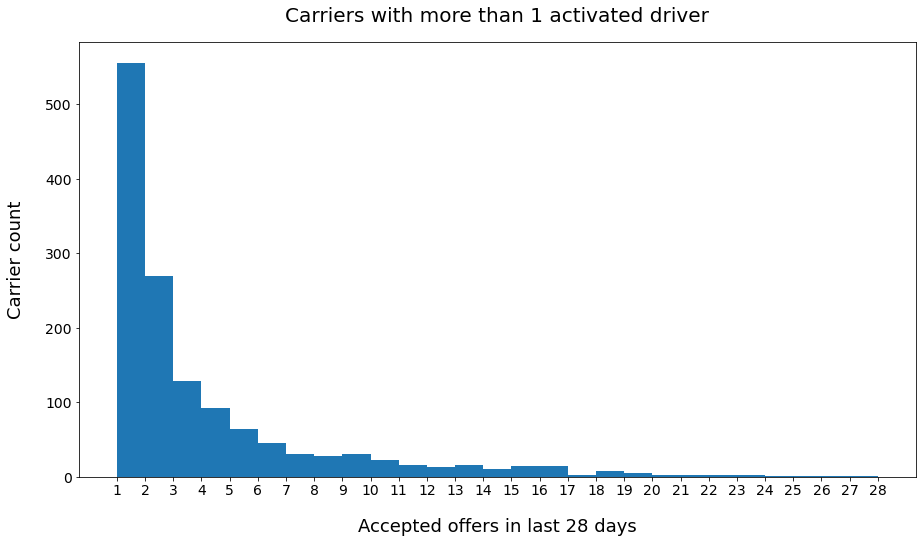

In [26]:
plt.figure(figsize=(15,8))
plt.hist(result_1[result_1['activated_drivers'] > 1]['accepted_offers_28_days'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Accepted offers in last 28 days', fontsize=18, labelpad=20)
plt.ylabel('Carrier count', fontsize=18, labelpad=20)
plt.title('Carriers with more than 1 activated driver', fontsize=20, pad=20)
plt.show()

# Results
Most carriers are only accepting offers 1 day out of 28. This histogram is still not close to representing our qualitative hypothesis. Our qualitative hypothesis is 1 accepted offer per carrier/per week/per driver. So our max value should be at least be 4. I don't recommend using this histogram, because carriers can accept multiple offers per day for multiple drivers. For example, a carrier can accept 15 offers for 15 different drivers in one day, and this would still show up as being ONE unique day of accepting offers. Thus, we are not getting an accaurate representation of accepted offers per driver.
### 1. Are we looking at the wrong users? 
Can we filter this user group in a way that more represents the persona of our qualitative hypothesis? We got our accpeted offers by carriers from the STMS database...Are their offers being accpeted by carriers that would not show up in the STMS database?
### 2. Are we not solving our users problem?  Are they using alternatives?

# Next steps
We need to get a better representation of offers accpeted per driver. So now I want to look at the number of offers accepted in the last 28 days for each specific driver.

In [27]:
# Creating a table of shipper offers
sql = '''
SELECT carrier_name, carrier_guid, id, order_id, guid, date(accepted_date), carrier_order_guid 
FROM stms_db2_shipper.offers
WHERE status IN ('paid', 'delivered', 'accepted', 'picked_up', 'invoiced')
AND accepted_date >= date(current_date - interval '28 days')
AND accepted_date < date(current_date)
'''
shipper_offers = pd.read_sql_query(sql, con=engine)
shipper_offers = shipper_offers.rename(columns={'date': 'accepted_date'})
shipper_offers.head()

,carrier_name,carrier_guid,id,order_id,guid,accepted_date,carrier_order_guid
0,WILD WEST EXPRESS LLC,949b20a1-566b-43fa-83a9-6a8cce770b1f,499164,1052784,f7744580-9a9e-4f23-9885-1899a430bca2,2020-12-08,None
1,DUTCHWAY FREIGHT LTD,70883b73-9d96-4752-879c-fe8901d57e26,500076,1053681,52bdca9e-7e6d-4e92-9847-ba7f949ba640,2020-12-08,None
2,ESTRADA'S TRANSPORTATION LLC,a59a4f98-7da5-4e20-a91a-58092ca9f83d,500136,1053756,7e502d7f-b512-47d1-8c00-330963d5895f,2020-12-08,None
3,AUTHENTIC AUTO TRANSPORT CO,b00970ac-6c41-4752-ae9d-b7d50fcbd2dd,500244,1053176,ea67a1ea-d5c4-45bf-9082-4d680dac4d2a,2020-12-08,None
4,REIGN CONSULTING,ed822e80-7e6a-48b6-8089-efd62f35292d,500280,1053889,f69e875e-ab9d-41ff-ab1e-c96ebdcd2003,2020-12-08,None


In [28]:
# Checking for missing values
shipper_offers.isna().sum()/shipper_offers.isna().count()

carrier_name          0.000000
carrier_guid          0.000031
id                    0.000000
order_id              0.000000
guid                  0.000000
accepted_date         0.000000
carrier_order_guid    0.908569
dtype: float64

The number of missing values is high for carrier_order_guid. I will join this 'shipping offers' table with the 'shipping orders' table to fill in these missing values.

In [29]:
# creating a shipping orders table
sql = '''
SELECT id, active_offer_id, guid, carrier_order_guid 
FROM stms_db2_shipper.orders
'''
shipper_orders = pd.read_sql_query(sql, con=engine)
shipper_orders.head()

,id,active_offer_id,guid,carrier_order_guid
0,945418,384157.0,2fa61eef-a8fa-4ebb-a82c-8037fb082cea,e78b0230-7642-462a-9be8-61ce0dd14050
1,945458,390119.0,709543ec-1051-497f-b4b8-845c6dafcc14,7adcb207-2107-401a-872e-d37755ad1900
2,945498,386140.0,684fbb74-0879-43d5-8d80-4db2059f4d9b,25d5412d-6999-4751-94ed-8275f555db08
3,945538,382932.0,de8a4b2b-6c95-43a1-8ae0-98537574c9cf,0aa77634-d1db-4543-aa0a-dcdb9ef90039
4,945578,383436.0,1e710b45-5d09-4b37-b206-4efa84c2215a,b1bf3099-d852-41d2-a7c7-984e68131e3c


In [30]:
# Joining 'shipper_orders' table with 'shipper_offers' table
shipper_offers_join1 = shipper_offers.merge(shipper_orders, how='left', left_on='id', right_on='active_offer_id',
                                      suffixes=('_shipper_offer_table', '_shipper_order_table'))
shipper_offers_join1.head()

,carrier_name,carrier_guid,id_shipper_offer_table,order_id,guid_shipper_offer_table,accepted_date,carrier_order_guid_shipper_offer_table,id_shipper_order_table,active_offer_id,guid_shipper_order_table,carrier_order_guid_shipper_order_table
0,WILD WEST EXPRESS LLC,949b20a1-566b-43fa-83a9-6a8cce770b1f,499164,1052784,f7744580-9a9e-4f23-9885-1899a430bca2,2020-12-08,None,1052784.0,499164.0,404c915e-6b6a-4885-bf55-9d8c6d526f20,ce3b6753-9c59-4bea-a341-7483f50e2ff3
1,DUTCHWAY FREIGHT LTD,70883b73-9d96-4752-879c-fe8901d57e26,500076,1053681,52bdca9e-7e6d-4e92-9847-ba7f949ba640,2020-12-08,None,1053681.0,500076.0,213fc2f6-7428-4f26-9c3f-eedfd8b484e5,4c0def3d-9cd0-413a-871d-71f120b43b47
2,ESTRADA'S TRANSPORTATION LLC,a59a4f98-7da5-4e20-a91a-58092ca9f83d,500136,1053756,7e502d7f-b512-47d1-8c00-330963d5895f,2020-12-08,None,1053756.0,500136.0,e99e7e14-7e52-47de-b02a-865726e9ac2c,60afc663-4157-40c3-aced-de3880667b74
3,AUTHENTIC AUTO TRANSPORT CO,b00970ac-6c41-4752-ae9d-b7d50fcbd2dd,500244,1053176,ea67a1ea-d5c4-45bf-9082-4d680dac4d2a,2020-12-08,None,1053176.0,500244.0,31dfb1ee-81a1-45c5-b2f8-b18540ff5e60,ec00d282-a596-4d32-b43f-7160077b3058
4,REIGN CONSULTING,ed822e80-7e6a-48b6-8089-efd62f35292d,500280,1053889,f69e875e-ab9d-41ff-ab1e-c96ebdcd2003,2020-12-08,None,1053889.0,500280.0,113f41b4-86cd-490b-bd68-1ad9952b99fb,e5c4e8cc-c0c5-42c3-a9a1-6067b28849c7


In [31]:
# checking for missing values again
shipper_offers_join1.isna().sum()/shipper_offers_join1.isna().count()

carrier_name                              0.000000
carrier_guid                              0.000031
id_shipper_offer_table                    0.000000
order_id                                  0.000000
guid_shipper_offer_table                  0.000000
accepted_date                             0.000000
carrier_order_guid_shipper_offer_table    0.908569
id_shipper_order_table                    0.000753
active_offer_id                           0.000753
guid_shipper_order_table                  0.000753
carrier_order_guid_shipper_order_table    0.011892
dtype: float64

After joining the tables the missing values for carrier_order_guid decreased to less than 2% of the rows.

In [32]:
# creating a table for carrier orders
sql = '''
SELECT driver_id, carrier_id, guid, id
FROM ctms_db_public.msd_order
'''
carrier_orders = pd.read_sql_query(sql, con=engine)
carrier_orders.head()

,driver_id,carrier_id,guid,id
0,10766.0,6700.0,3cc6dc2a-6abe-43cf-8f10-3da6c397c6fe,2083829
1,7012.0,3111.0,0f5f4b62-88e4-4b49-9f74-52db80225a86,2085325
2,15575.0,1278.0,99bd0e12-3132-4d95-8614-2a9758392eee,2086733
3,23847.0,3552.0,080afb14-0ca8-48db-b2f2-87d799e41136,2088141
4,25942.0,18414.0,96f9d0f0-14ed-4729-b447-fb548a0a6884,2089549


In [33]:
# joining carrier orders table with shipper offers table
carrier_orders_join = shipper_offers_join1.merge(carrier_orders, how='left',
                                                 left_on='carrier_order_guid_shipper_order_table', right_on='guid',
                                                 suffixes=('_shipper_offer', '_shipper_order'))

carrier_orders_join.head()

,carrier_name,carrier_guid,id_shipper_offer_table,order_id,guid_shipper_offer_table,accepted_date,carrier_order_guid_shipper_offer_table,id_shipper_order_table,active_offer_id,guid_shipper_order_table,carrier_order_guid_shipper_order_table,driver_id,carrier_id,guid,id
0,WILD WEST EXPRESS LLC,949b20a1-566b-43fa-83a9-6a8cce770b1f,499164,1052784,f7744580-9a9e-4f23-9885-1899a430bca2,2020-12-08,None,1052784.0,499164.0,404c915e-6b6a-4885-bf55-9d8c6d526f20,ce3b6753-9c59-4bea-a341-7483f50e2ff3,56982.0,34594.0,ce3b6753-9c59-4bea-a341-7483f50e2ff3,7723503.0
1,DUTCHWAY FREIGHT LTD,70883b73-9d96-4752-879c-fe8901d57e26,500076,1053681,52bdca9e-7e6d-4e92-9847-ba7f949ba640,2020-12-08,None,1053681.0,500076.0,213fc2f6-7428-4f26-9c3f-eedfd8b484e5,4c0def3d-9cd0-413a-871d-71f120b43b47,76676.0,41018.0,4c0def3d-9cd0-413a-871d-71f120b43b47,7729348.0
2,ESTRADA'S TRANSPORTATION LLC,a59a4f98-7da5-4e20-a91a-58092ca9f83d,500136,1053756,7e502d7f-b512-47d1-8c00-330963d5895f,2020-12-08,None,1053756.0,500136.0,e99e7e14-7e52-47de-b02a-865726e9ac2c,60afc663-4157-40c3-aced-de3880667b74,77235.0,41213.0,60afc663-4157-40c3-aced-de3880667b74,7729798.0
3,AUTHENTIC AUTO TRANSPORT CO,b00970ac-6c41-4752-ae9d-b7d50fcbd2dd,500244,1053176,ea67a1ea-d5c4-45bf-9082-4d680dac4d2a,2020-12-08,None,1053176.0,500244.0,31dfb1ee-81a1-45c5-b2f8-b18540ff5e60,ec00d282-a596-4d32-b43f-7160077b3058,59360.0,35421.0,ec00d282-a596-4d32-b43f-7160077b3058,7730599.0
4,REIGN CONSULTING,ed822e80-7e6a-48b6-8089-efd62f35292d,500280,1053889,f69e875e-ab9d-41ff-ab1e-c96ebdcd2003,2020-12-08,None,1053889.0,500280.0,113f41b4-86cd-490b-bd68-1ad9952b99fb,e5c4e8cc-c0c5-42c3-a9a1-6067b28849c7,69255.0,38608.0,e5c4e8cc-c0c5-42c3-a9a1-6067b28849c7,7730760.0


In [34]:
# joining driver info with the carrier orders table
carrier_orders_with_driver = carrier_orders_join.merge(drivers, how='left',
                                                  left_on='driver_id', right_on='genericuser_ptr_id')
carrier_orders_with_driver.head()

,carrier_name,carrier_guid_x,id_shipper_offer_table,order_id,guid_shipper_offer_table,accepted_date,carrier_order_guid_shipper_offer_table,id_shipper_order_table,active_offer_id,guid_shipper_order_table,carrier_order_guid_shipper_order_table,driver_id,carrier_id_x,guid,id,genericuser_ptr_id,carrier_id_y,driver_guid,name,carrier_guid_y
0,WILD WEST EXPRESS LLC,949b20a1-566b-43fa-83a9-6a8cce770b1f,499164,1052784,f7744580-9a9e-4f23-9885-1899a430bca2,2020-12-08,None,1052784.0,499164.0,404c915e-6b6a-4885-bf55-9d8c6d526f20,ce3b6753-9c59-4bea-a341-7483f50e2ff3,56982.0,34594.0,ce3b6753-9c59-4bea-a341-7483f50e2ff3,7723503.0,56982.0,34594.0,c041901c-8eb8-49c4-9df8-68b7974f51b6,WILD WEST EXPRESS LLC,949b20a1-566b-43fa-83a9-6a8cce770b1f
1,DUTCHWAY FREIGHT LTD,70883b73-9d96-4752-879c-fe8901d57e26,500076,1053681,52bdca9e-7e6d-4e92-9847-ba7f949ba640,2020-12-08,None,1053681.0,500076.0,213fc2f6-7428-4f26-9c3f-eedfd8b484e5,4c0def3d-9cd0-413a-871d-71f120b43b47,76676.0,41018.0,4c0def3d-9cd0-413a-871d-71f120b43b47,7729348.0,76676.0,41018.0,25a596ca-7367-47c8-ba0f-07d6de3850b6,DUTCHWAY FREIGHT LTD,70883b73-9d96-4752-879c-fe8901d57e26
2,ESTRADA'S TRANSPORTATION LLC,a59a4f98-7da5-4e20-a91a-58092ca9f83d,500136,1053756,7e502d7f-b512-47d1-8c00-330963d5895f,2020-12-08,None,1053756.0,500136.0,e99e7e14-7e52-47de-b02a-865726e9ac2c,60afc663-4157-40c3-aced-de3880667b74,77235.0,41213.0,60afc663-4157-40c3-aced-de3880667b74,7729798.0,77235.0,41213.0,18a33f55-c3a1-443a-bf75-6927b6e4b96e,ESTRADA'S TRANSPORTATION LLC,a59a4f98-7da5-4e20-a91a-58092ca9f83d
3,AUTHENTIC AUTO TRANSPORT CO,b00970ac-6c41-4752-ae9d-b7d50fcbd2dd,500244,1053176,ea67a1ea-d5c4-45bf-9082-4d680dac4d2a,2020-12-08,None,1053176.0,500244.0,31dfb1ee-81a1-45c5-b2f8-b18540ff5e60,ec00d282-a596-4d32-b43f-7160077b3058,59360.0,35421.0,ec00d282-a596-4d32-b43f-7160077b3058,7730599.0,59360.0,35421.0,4e61f9c7-536e-476e-a949-e26e192aebba,AUTHENTIC AUTO TRANSPORT CO,b00970ac-6c41-4752-ae9d-b7d50fcbd2dd
4,REIGN CONSULTING,ed822e80-7e6a-48b6-8089-efd62f35292d,500280,1053889,f69e875e-ab9d-41ff-ab1e-c96ebdcd2003,2020-12-08,None,1053889.0,500280.0,113f41b4-86cd-490b-bd68-1ad9952b99fb,e5c4e8cc-c0c5-42c3-a9a1-6067b28849c7,69255.0,38608.0,e5c4e8cc-c0c5-42c3-a9a1-6067b28849c7,7730760.0,69255.0,38608.0,101f0b62-bee1-4875-9e4c-23fa2b72081e,REIGN CONSULTING,ed822e80-7e6a-48b6-8089-efd62f35292d


In [35]:
# percentage of missing values in every column
carrier_orders_with_driver.isna().sum()/carrier_orders_with_driver.isna().count()

carrier_name                              0.000000
carrier_guid_x                            0.000031
id_shipper_offer_table                    0.000000
order_id                                  0.000000
guid_shipper_offer_table                  0.000000
accepted_date                             0.000000
carrier_order_guid_shipper_offer_table    0.908569
id_shipper_order_table                    0.000753
active_offer_id                           0.000753
guid_shipper_order_table                  0.000753
carrier_order_guid_shipper_order_table    0.011892
driver_id                                 0.118886
carrier_id_x                              0.012394
guid                                      0.012394
id                                        0.012394
genericuser_ptr_id                        0.135609
carrier_id_y                              0.135609
driver_guid                               0.135609
name                                      0.135609
carrier_guid_y                 

In [36]:
# dropping all rows where driver_guid is missing
carrier_orders_with_driver.dropna(subset=['driver_guid'], inplace=True)
carrier_orders_with_driver.isna().sum()

carrier_name                                  0
carrier_guid_x                                0
id_shipper_offer_table                        0
order_id                                      0
guid_shipper_offer_table                      0
accepted_date                                 0
carrier_order_guid_shipper_offer_table    24972
id_shipper_order_table                        0
active_offer_id                               0
guid_shipper_order_table                      0
carrier_order_guid_shipper_order_table        0
driver_id                                     0
carrier_id_x                                  0
guid                                          0
id                                            0
genericuser_ptr_id                            0
carrier_id_y                                  0
driver_guid                                   0
name                                          0
carrier_guid_y                                0
dtype: int64

All missing values in useful columns have been handled.

In [37]:
# Getting the unique number of accepted offers by grouping driver and carrier information
result_2 = carrier_orders_with_driver.groupby(['driver_id', 'driver_guid', 'carrier_name'])[['accepted_date']].nunique()
result_2.reset_index(inplace=True)
result_2 = result_2.rename(columns={'accepted_date': 'accepted_loads_28_days'})
result_2

,driver_id,driver_guid,carrier_name,accepted_loads_28_days
0,634.0,787b5d1f-2f7e-438c-89d2-d3c3e90d6e06,Stein Auto Transport Llc,1
1,789.0,57a3e202-1bc7-4980-b317-2e40d108cd62,Palidin Enterprises LLC,2
2,1297.0,4d8f0c1d-2abe-4f23-86f8-2f62156bd0bb,"In Time , inc",1
3,1616.0,f77d50be-9014-4310-b779-2cecdb20dcea,UZ Auto Trans Inc,2
4,1733.0,1ed25e5f-2221-4c2e-8938-0cace564678f,KK Auto Trans LLC,1
...,...,...,...,...
3847,84292.0,a9f4599a-98e1-4018-a515-8ce51bc5383c,FIELDS TRUCKING LLC,1
3848,84294.0,421eb6a4-c2d6-4c89-b236-2c799ecf4dc4,Gig Logistics inc,1
3849,84296.0,f546e926-a431-41ea-9965-bd19ea374c7c,MCCONNELL TRUCKING,2
3850,84350.0,711fa861-8447-4a5f-b7c2-388c19c0344f,Epic 1,1


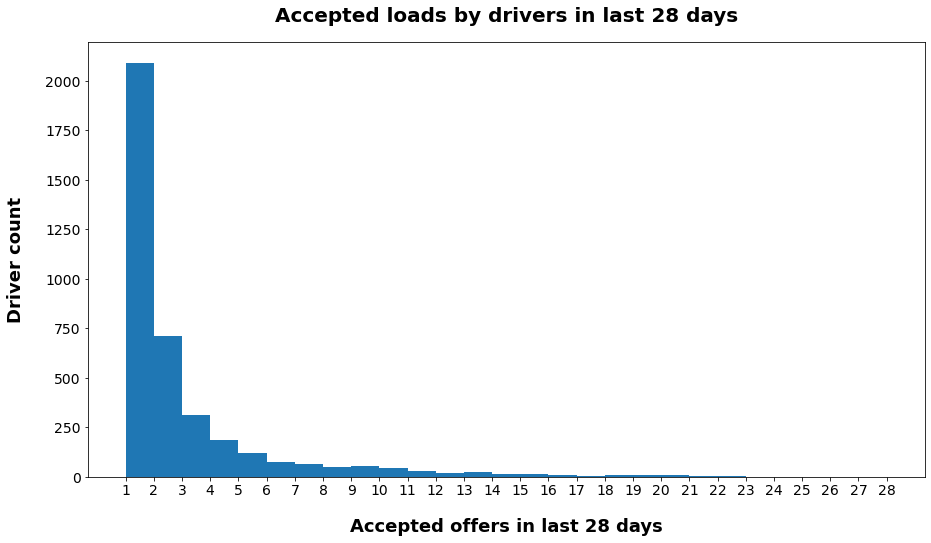

In [38]:
# histogram for accepted offers by specific drivers
plt.figure(figsize=(15,8))
plt.hist(result_2['accepted_loads_28_days'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Accepted offers in last 28 days', fontsize=18, fontweight='bold', labelpad=20)
plt.ylabel('Driver count', fontsize=18, fontweight='bold', labelpad=20)
plt.title('Accepted loads by drivers in last 28 days', fontsize=20, fontweight='bold',  pad=20)
plt.show()

# Results
Most drivers are only accepting offers 1 day out of 28. This histogram is still not close to representing our qualitative hypothesis. Our qualitative hypothesis is 1 accepted offer per carrier/per week/per driver. So our max value should be 4.
### 1. Are we looking at the wrong users? 
Can we filter this user group in a way that more represents the persona of our qualitative hypothesis? We got our accpeted offers by carriers from the STMS database...Are their offers being accpeted by carriers that would not show up in the STMS database?
### 2. Are we not solving our users problem?  Are they using alternatives?

# Results
Most cariers are only averaging 1 accepted offer per driver out of 28 days. This histogram is still not close to representing our qualitative hypothesis. Our qualitative hypothesis is 1 accepted offer per carrier/per week/per driver. So our max value should be around 4.
### 1. Are we looking at the wrong users? 
Can we filter this user group in a way that more represents the persona of our qualitative hypothesis? We got our accpeted offers by carriers from the STMS database...Are their offers being accpeted by carriers that would not show up in the STMS database?
### 2. Are we not solving our users problem?  Are they using alternatives? 

# Conclusion
- None of our results came close to our qualitative hypothesis,
- Possible reassons for this include incorrect estimation of our qualitiative hypothesis, looking at the wrong users, were not solving our users problems, faulty data, etc.
- I recommend not using this metric for our retention analysis until our results better match our qualitative hypothesis.

# next steps - Segment this with paid users vs non-paid users